# Τεχνητή Νοημοσύνη: Θέμα 3

---
Ζωγράφος Ορφέας  
A.M.: 03117160

Κωστόπουλος Κωνσταντίνος  
A.M.: 03117043

---

## Λύση

### Μέρος 1: Αξιολόγηση ###  
---

In [1]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import numpy as np
import random

class Evaluate:
    def __init__(self,y_true,y_pred,x):
      self.y_true = y_true
      self.y_pred = y_pred
      self.x = x

    def my_accuracy(self):
      y_true = self.y_true
      y_pred = self.y_pred
      ##################
      ## Your code below
      true_len = len(y_true)
      pred_len = len(y_pred)
      assert true_len == pred_len, "Number of predictions and facts should be equal"
      count_correct = 0
      for i in range(pred_len):
        if y_true[i] == y_pred[i]: count_correct = count_correct + 1
      
      acc = count_correct / true_len
      ## Your code above
      ##################
      return acc

    def get_metrics(self):
        precision = precision_score(self.y_true, self.y_pred, average = "macro")
        recall = recall_score(self.y_true, self.y_pred, average = "macro")
        f1 = f1_score(self.y_true, self.y_pred, average = "macro")
        results = {"precision" : precision, "recall": recall, "f1": f1,"accuracy":self.my_accuracy()}
        return results   
    
    def confusion_matrix(self):
        cm = confusion_matrix(self.y_true, self.y_pred)
        return cm 

    def get_sample_of_wrong(self, rows = 5, lines = 4):
        wrong_indexes = [index for index in range(len(self.y_true)) if self.y_true[index] != self.y_pred[index]]
        plt.figure(figsize=(10, 10))

        random.shuffle(wrong_indexes)
        for i, index in enumerate(wrong_indexes[: rows*lines]):
            plt.subplot(rows, lines, i + 1)
            image = self.x[index]
            plt.imshow(image.reshape((28, 28)))
            plt.title("Real: {}, Pred: {}".format(self.y_true[index], self.y_pred[index]))
            plt.axis('off')

    def get_evaluation_report(self):
       metrics = self.get_metrics()
       for m in metrics:
         print(m+' : '+str(metrics[m]))
       cm = self.confusion_matrix()
       print("Confusion matrix: ")
       print(cm)
       print("Some images with wrong predictions")
       self.get_sample_of_wrong()

Παράδειγμα χρήσης:

precision : 0.7000000000000001
recall : 0.6944444444444443
f1 : 0.6888888888888888
accuracy : 0.625
Confusion matrix: 
[[3 1 0]
 [2 1 0]
 [0 0 1]]
Some images with wrong predictions


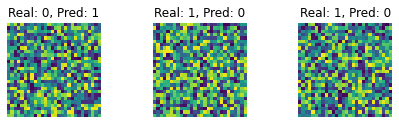

In [ ]:
y_true = [1,0,2,0,0,1,1,0]
y_pred = [0,0,2,0,1,1,0,0]
x = np.random.rand(8,28*28)

eval = Evaluate(y_true,y_pred,x)
eval.get_evaluation_report()

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

train_dset = pd.read_csv('/content/sample_data/mnist_train_small.csv',header=None)
test_dset = pd.read_csv('/content/sample_data/mnist_test.csv',header=None)
## From https://colab.research.google.com/notebooks/mlcc/multi-class_classification_of_handwritten_digits.ipynb#scrollTo=JfFWWvMWDFrR
def parse_labels_and_features(dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset[0]

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.loc[:,1:784]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features / 255

  return labels, np.array(features)

def show_image(features):
  img = features.reshape((28,28))
  plt.imshow(img)
  plt.show()

y_train,x_train = parse_labels_and_features(train_dset)
y_test,x_test = parse_labels_and_features(test_dset)

Μορφή των δεδομένων:

In [3]:
print("Shape of an image: "+str(x_train[0].shape))
print("Max value of pixel: "+str(np.max(x_train[0])))

Shape of an image: (784,)
Max value of pixel: 1.0


Και μια εικόνα ως δείγμα:

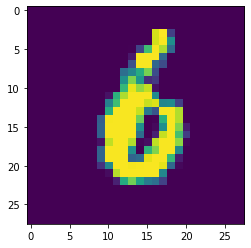

Label = 6


In [ ]:
i = np.random.randint(0,x_train.shape[0])
show_image(x_train[i])
print("Label = " +str(y_train[i]))

In [ ]:
len(x_train)

20000

### Μέρος 2: Υλοποίηση ΚΝΝ ###  
---

In [ ]:
## Simple KNN
from numba import njit
import numpy as np

@njit
def get_distance_fast(img1, img2, distance_type):
  ## Compute the distance between the two vectors img1 and img2
  temp1 = np.copy(img1)
  temp2 = np.copy(img2)
  if distance_type == 'euclidian':
    dist = np.linalg.norm(temp1 - temp2)
  elif distance_type == 'cosine':
    dist = 1 - (np.dot(temp1,temp2)/ (np.linalg.norm(temp1) * np.linalg.norm(temp2)))
  return dist

@njit
def get_knn_fast(img, x, k, distance_type):
  ## Given an image as a vector, returns indexes of k nearest neighbors
  temp = len(x)
  distances = np.zeros(temp)
  for i in range(temp):
    distances[i] = get_distance_fast(img, x[i], distance_type)

  ans_indexes = np.argsort(distances)[:k]
  return ans_indexes

@njit
def classify_fast(img, y, x, k, distance_type):
  ## Given an image as a vector, classify it according to KNN
  knn_res = get_knn_fast(img,x,k,distance_type)
  nn_labels = np.asarray([y[i] for i in knn_res], dtype=np.int64)

  prediction = np.argmax(np.bincount(nn_labels))
  return prediction

class KNN:
  def __init__(self,x,y,k,distance="euclidian"):
    self.x = x
    self.y = y
    self.k = k
    self.distance = distance
  
  def classify(self,img):
    return classify_fast(img, self.y.to_numpy(dtype=np.int64), self.x, self.k, self.distance)


knn = KNN(x_train,y_train,k=5,distance='euclidian')

Input image: 


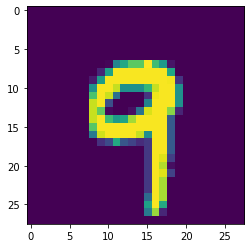

Prediction : 9


In [ ]:
img = x_test[np.random.randint(0,x_test.shape[0])]
print("Input image: ")
show_image(img)
print('Prediction : '+str(knn.classify(img)))

#### Αξιολόγηση του KNN

In [ ]:
knn = KNN(x_train,y_train,k=5,distance='euclidian')
preds = [knn.classify(x_test[i]) for i in range(100)]
labels = [y_test[i] for i in range(100)]

precision : 0.9749019607843138
recall : 0.9568181818181818
f1 : 0.962567733990148
accuracy : 0.96
Confusion matrix: 
[[ 8  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0]
 [ 0  1  6  0  0  0  0  1  0  0]
 [ 0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  1  0  0  1  0  9]]
Some images with wrong predictions


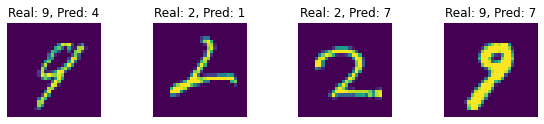

In [ ]:
eval = Evaluate(labels,preds,x_test[:100])
eval.get_evaluation_report()

#### Έτοιμος KNN clasifier

precision : 0.9749019607843138
recall : 0.9568181818181818
f1 : 0.962567733990148
accuracy : 0.96
Confusion matrix: 
[[ 8  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0]
 [ 0  1  6  0  0  0  0  1  0  0]
 [ 0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  1  0  0  1  0  9]]
Some images with wrong predictions


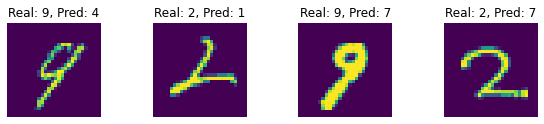

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k = 5
knc = KNeighborsClassifier(n_neighbors=k)
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test[:100])

eval = Evaluate(y_test[:100],y_pred,x_test[:100])
eval.get_evaluation_report()

#### Σύγκριση υλοποιήσεων

##### Χρόνος

In [ ]:
%%time
knn = KNN(x_train,y_train,k=5,distance='euclidian')
preds = [knn.classify(x_test[i]) for i in range(100)]

CPU times: user 9.67 s, sys: 8.94 ms, total: 9.68 s
Wall time: 9.75 s


In [ ]:
%%time
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test[:100])

CPU times: user 6.66 s, sys: 11.9 ms, total: 6.67 s
Wall time: 6.72 s


##### Απόδοση

In [ ]:
def test_k_vals(distance_metric):
  results = {}
  for k_val in range(1,10):
    knn = KNN(x_train,y_train,k=k_val,distance=distance_metric)
    preds = [knn.classify(x_test[i]) for i in range(200)]
    labels = [y_test[i] for i in range(200)]
    eval = Evaluate(labels,preds,x_test[:200])
    results[k_val] = eval.get_metrics()
  return results
temp = test_k_vals('euclidian')
for i in temp: print(i, "->", temp[i])
print("----")
temp = test_k_vals('cosine')
for i in temp: print(i, "->", temp[i])

1 -> {'precision': 0.9789952065814134, 'recall': 0.9755952380952382, 'f1': 0.9769236871010261, 'accuracy': 0.975}
2 -> {'precision': 0.9543299621525426, 'recall': 0.9428571428571428, 'f1': 0.9469351891011122, 'accuracy': 0.95}
3 -> {'precision': 0.9756620920309077, 'recall': 0.9720238095238095, 'f1': 0.9732548683070148, 'accuracy': 0.97}
4 -> {'precision': 0.9708195970695972, 'recall': 0.9581547619047619, 'f1': 0.9634833978343671, 'accuracy': 0.965}
5 -> {'precision': 0.9708195970695972, 'recall': 0.9581547619047619, 'f1': 0.9634833978343671, 'accuracy': 0.965}
6 -> {'precision': 0.9712362637362638, 'recall': 0.9556547619047621, 'f1': 0.9609333108538458, 'accuracy': 0.96}
7 -> {'precision': 0.9704090909090908, 'recall': 0.95625, 'f1': 0.960904437612186, 'accuracy': 0.96}
8 -> {'precision': 0.9682770562770562, 'recall': 0.9514880952380953, 'f1': 0.9572808072294453, 'accuracy': 0.955}
9 -> {'precision': 0.9605620509073194, 'recall': 0.943154761904762, 'f1': 0.9490775239402556, 'accuracy'

##### Σχολιασμός

* Παρόλο που με χρήση της βιβιλιοθήκης ` numba ` καταφέραμε να μειώσουμε αρκετά το running time (πράγμα που επαληθεύτηκε και μέσω δοκιμών) η υλοποίηση της βιβλιοθήκης ` sklearn ` συνεχίζει να είναι αισθητά πιό γρήγορη. 
* Πιθανή βελτιστοποίηση της χρονικής απόδοσης θα ήταν στον υπολογισμό της Ευκλίδειας απόστασης να μην υπολογίζουμε τη ρίζα του αθροίσματος των τετραγώνων των διαφορών αφού η διάταξη των αποστάσεων συντηρείται.
* Ωστόσο ως προς τις απαντήσεις, η επίδοση της έτοιμης υλοποίησης και της δικιάς μας σε όλες τις δοκιμές που κάναμε είναι ίδια.
* Παρατηρούμε ακόμη ότι όσον αφορά την `'cosine'` απόσταση η δομή του dataset ή/και του προβλήματος οδηγεί σε καλύτερο αποτέλεσμα για μικρότερη τιμή του `k`

### Μέρος 3: Naive Bayes ###  
---

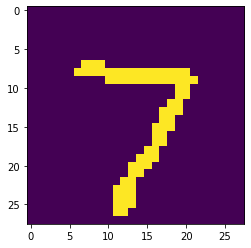

In [ ]:
## Στρογγυλοποίηση:
x_train_r = np.round(x_train)
x_test_r = np.round(x_test)
show_image(x_test_r[0])

In [ ]:
@njit
def comp_prob_fast(x, y, pC, pxC):
  for label in y:
    pC[label] += 1
  pC = pC/y.shape[0]

  for pixel in range(x.shape[-1]):
    for i in range(len(y)):
      pxC[pixel][y[i]] += x[i][pixel]
  
  for i in range(10):
    for pixel in range(x.shape[-1]):
      pxC[pixel][i] /= pC[i] * y.shape[0]
  return pxC

@njit
def predict_fast(x, pxC, pC,):
  pcX = np.ones((10,))
  for i in range(10):
    pcX[i] = pC[i]
    for pixel in range(x.shape[-1]):
      if x[pixel] == 1.:
        pcX[i] *= pxC[pixel][i]
      elif x[pixel] == 0.:
        pcX[i] *= 1 - pxC[pixel][i]
  return np.argmax(pcX)

class NaiveBayes:
  def __init__(self,x,y):
    self.x = x
    self.y = y
    ## pC is a vector with the probability of each class
    self.pC = np.zeros((10,))
    ## pxC is an array with all probabilities p(xi|C)
    self.pxC = np.zeros((x.shape[-1],10))
    ## Compute the probabilities
    self.compute_probabilities()

  def compute_probabilities(self):
    ## Compute p(C) for each class    
    self.pxC = comp_prob_fast(self.x, self.y.to_numpy(dtype=np.int64), self.pC, self.pxC)

  def predict(self,x):
    ## ~Probability of x belonging to each class
    return predict_fast(x, self.pxC, self.pC)

#### Αξιολόγηση του Naive Bayes

precision : 0.8400974025974026
recall : 0.850108225108225
f1 : 0.8261529454950507
accuracy : 0.85
Confusion matrix: 
[[ 7  0  0  0  0  0  0  0  1  0]
 [ 0 13  0  1  0  0  0  0  0  0]
 [ 0  0  7  1  0  0  0  0  0  0]
 [ 0  0  1 10  0  0  0  0  0  0]
 [ 1  0  0  0 12  0  0  0  0  1]
 [ 0  0  0  2  1  4  0  0  0  0]
 [ 0  0  2  0  0  0  8  0  0  0]
 [ 0  0  1  0  0  0  0 13  0  1]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  1  0  0  0  1  9]]
Some images with wrong predictions


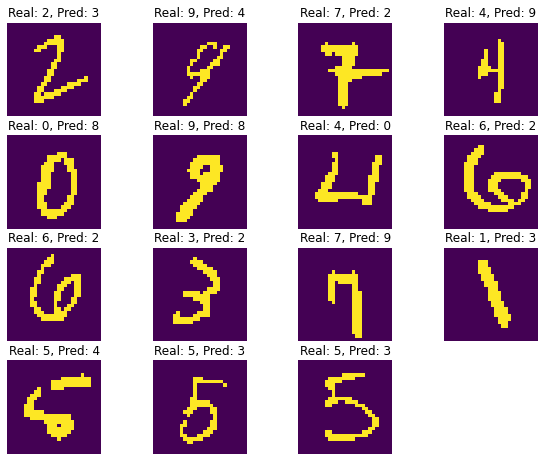

In [ ]:
nb = NaiveBayes(x_train_r,y_train)
preds = [ nb.predict(i) for i in x_test_r[:100]]
eval = Evaluate(y_test[:100], preds, x_test_r[:100])
eval.get_evaluation_report()

#### Έτοιμος Naive Bayes

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision : 0.5992985558502799
recall : 0.5716774891774892
f1 : 0.5081873844349185
accuracy : 0.6
Confusion matrix: 
[[ 7  0  0  0  0  0  0  0  0  1]
 [ 0 14  0  0  0  0  0  0  0  0]
 [ 3  0  2  0  0  0  2  0  0  1]
 [ 0  0  1  3  0  0  1  0  5  1]
 [ 1  1  0  0  4  0  0  0  0  8]
 [ 2  0  0  0  1  0  0  0  3  1]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  1  0  0  0  0  8  0  6]
 [ 1  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 11]]
Some images with wrong predictions


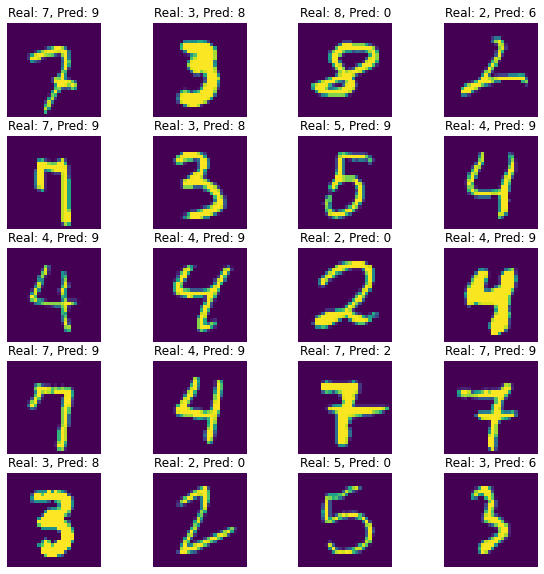

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test[:100])

eval = Evaluate(y_test[:100], y_pred, x_test[:100])
eval.get_evaluation_report()

#### Σύγκριση υλοποιήσεων

##### Χρόνος

In [ ]:
%%time
nb = NaiveBayes(x_train_r,y_train)
preds = [ nb.predict(i) for i in x_test_r]

CPU times: user 274 ms, sys: 0 ns, total: 274 ms
Wall time: 285 ms


In [ ]:
%%time
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)

CPU times: user 737 ms, sys: 2.99 ms, total: 740 ms
Wall time: 742 ms


##### Απόδοση

In [ ]:
from sklearn.naive_bayes import GaussianNB

print("Δικιά μας υλοποίηση:")
nb = NaiveBayes(x_train_r,y_train)
preds = [ nb.predict(i) for i in x_test_r]
eval = Evaluate(y_test, preds, x_test_r)
print(eval.get_metrics())

print("---")
print("Έτοιμη υλοποίηση:")
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)

eval = Evaluate(y_test, y_pred, x_test)
print(eval.get_metrics())

Δικιά μας υλοποίηση:
{'precision': 0.8420769694261152, 'recall': 0.8386732815442702, 'f1': 0.839392796785908, 'accuracy': 0.8411}
---
Έτοιμη υλοποίηση:
{'precision': 0.6786218997566938, 'recall': 0.5528163449706252, 'f1': 0.5175091463233913, 'accuracy': 0.5602}


##### Σχολιασμός
Η υλοποίησή μας έγινε υπό την υπόθεση της δεσμευμένης ανεξαρτησίας.

* Εδώ με χρήση της βιβλιοθήκης `numba` η βελτίωση χρονικά ήταν ιδιαίτερα αισθητή και οδήγησε μάλιστα σε γρηγορότερη εκτέλεση από την ήδη υπάρχουσα υλοποίηση (παρόλο που δε μπορούμε να κάνουμε 1 προς 1 σύγκριση αφού έγιναν διαφορετικές παραδοχές μεταξύ των υλοποιήσεων)
* Ακόμη η δική μας υλοποίηση αποδίδει καλύτερα και όσον αφορά τις μετρικές απόδοσης που χρησιμοποιούμε (που ίσως συνεπάγεται ότι η παραδοχή κανονικής κατανομής της υπάρχουσας είναι πιό άστοχη από αυτή της δεσμευμένης ανεξαρτησίας, τουλάχιστον για το συγκεκριμένο dataset και ίσως γενικότερα για το πρόβλημα)
* Παρόλα αυτά αξίζει να σημειωθεί ότι η συγκεκριμένη μέθοδος ταξινόμισης είναι αισθητά πιό γρήγορη (αρκετά για να επιτρέψει τη δοκιμή των ταξινομητών σε ολόκληρο το test_set) και η απόδοσή της είναι αποδεκτά χειρότερη, ειδικά αν λάβουμε υπόψιν ότι με κάποια καλύτερη παραδοχή ίσως να μπορούσαμε να πετύχουμε ακόμα καλύτερα αποτελέσματα

### Μέρος 4: Multi-Layer Perceptron ###  
---

Layer Interface

In [5]:
from numba import njit
class Layer:
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

ReLu Layer implementation

In [6]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad

Softmax 

In [7]:
# @njit
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    return xentropy

# @njit
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

Dense Layer Implementation

In [18]:
@njit
def dense_forward_fast(input, weights, biases, output_units):
  return np.dot(input,weights) + biases

# @njit
# def dense_backward_fast(input, grad_output, weights, biases, learning_rate, grad_biases):
#   grad_input = np.dot(grad_output, weights.T)
#   grad_weights = np.dot(input.T, grad_output)

#   assert grad_weights.shape == weights.shape and grad_biases.shape == biases.shape
#   ret_weights = weights - learning_rate * grad_weights
#   ret_biases = biases - learning_rate *grad_biases
#   return grad_input, ret_weights, ret_biases

class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.15):
        """
        Weight Initialization
        """
        self.input_units = input_units
        self.output_units = output_units
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [number of inputs, input units]
        output shape: [number of inputs, output units]
        """
        return dense_forward_fast(input,self.weights,self.biases,self.output_units)
    
    def backward(self,input,grad_output):
        # grad_biases = grad_output.mean(axis=0)*input.shape[0]
        # grad_input, self.weights, self.biases = dense_backward_fast(input, grad_output, self.weights, self.biases, self.learning_rate, grad_biases)
        #######################
        grad_input = np.dot(grad_output, self.weights.T)

        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

Multi-layered perceptron

In [9]:
class MLP:
    def __init__(self, shapes, input_dim):
        '''
        Κατασκευή του MLP. Τα επίπεδα και το μέγεθός τους ορίζεται από την μεταβλήτη shape, ενώ
        το μέγεθος της εισόδου ορίζεται από την μεταβλήτη input_dim
        '''
        self.shapes = shapes
        self.network = [Dense(input_dim, shapes[0])]
        self.network.append(ReLU())
        for i in range(1, len(self.shapes) - 1):
            self.network.append(Dense(shapes[i-1],shapes[i]))
            self.network.append(ReLU())
        self.network.append(Dense(shapes[i],shapes[-1]))

    def forward(self, X):
        """
        Αγόριθμος διφάνειας 33
        """
        activations = []
        input = X
        # Looping through each layer
        for l in self.network:
            ###################
            ## Your code below
            # hint: τροφοδοτούμε την έξοδο κάθε επιπέδου στο επόμενο
            
            input = l.forward(input)
            activations.append(input)
            ## Your code above
            ##################        
        assert len(activations) == len(self.network)
        return activations

    def predict(self,X):
        """
        Προβλέπει την έξοδο του δικτύου για ένα ή περισσότερα στιγμιότυπα εισόδου
        """
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)

    def fit(self, X, y):
        # Get the layer activations
        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
        logits = layer_activations[-1]
        
        # Compute the loss and the initial gradient
        loss = softmax_crossentropy_with_logits(logits,y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
        
        # Propagate gradients through the network
        # Reverse propogation as this is backprop
        for layer_index in range(len(self.network))[::-1]:
            layer = self.network[layer_index]
            loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        return np.mean(loss)

#### Αξιολόγηση ενός Multi-Layer Perceptron

Epoch 24
Train accuracy: 0.7775
Val accuracy: 0.7803


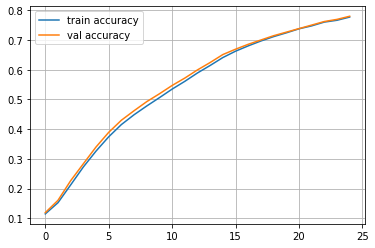

precision : 0.7871468660365344
recall : 0.7728877369840871
f1 : 0.7622743798326319
accuracy : 0.7803
Confusion matrix: 
[[ 917    0   10    7    0   10   20    3   13    0]
 [   0 1096    8    3    0    1    3    0   24    0]
 [  24   78  775   20   31    0   45   18   41    0]
 [  20   25   38  837    4   11    1   29   37    8]
 [   4    4    5    0  814    0   26    1   19  109]
 [  47   21   35  250   17  242   67   54  119   40]
 [  31   27   44    1   19    0  823    1   12    0]
 [   4   28   24    2   22    2    3  865   45   33]
 [  12   47   35   64   27    6   26   18  727   12]
 [  14    5    8    7  177    6    2   60   23  707]]
Some images with wrong predictions


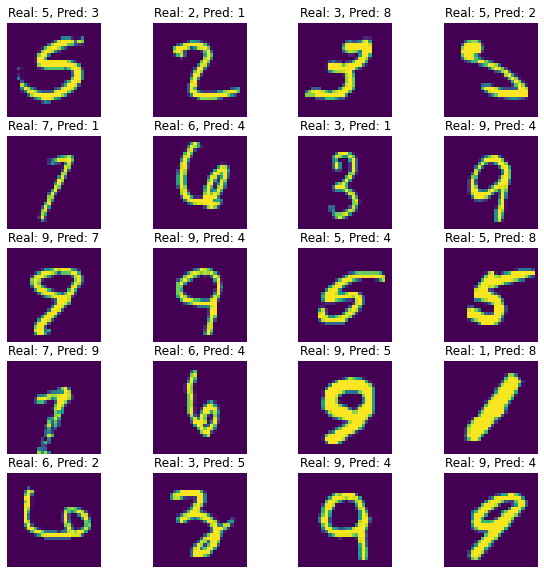

In [19]:
from IPython.display import clear_output
import numpy as np

network = MLP([100, 200, 100, 10], 28*28)

train_log = []
val_log = []

#Αυτά πρέπει να τρέχουν αφού έχετε φτιάξει σωστά τον κώδικα της MLP
for epoch in range(25):
    network.fit(x_train,y_train)
    
    train_log.append(np.mean(network.predict(x_train)==y_train))
    val_log.append(np.mean(network.predict(x_test)==y_test))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

y_pred = network.predict(x_test)

eval = Evaluate(y_test, y_pred, x_test)
eval.get_evaluation_report()

#### Έτοιμο Multi-Layer Perceptron

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


precision : 0.9646006678240227
recall : 0.9635197658176085
f1 : 0.9638315805230194
accuracy : 0.9642
Confusion matrix: 
[[ 960    1    2    2    0    3    4    3    2    3]
 [   0 1123    4    2    0    1    3    1    1    0]
 [   2    2  996   14    2    0    2   11    3    0]
 [   0    0    2  995    0    1    0    6    4    2]
 [   0    0    3    0  945    0    1    0    1   32]
 [   3    0    1   25    2  845    7    1    4    4]
 [   9    3    4    1   13   12  911    2    3    0]
 [   0    3   11    6    2    0    0  994    1   11]
 [   4    2    4   23    2   11    4    8  902   14]
 [   1    3    0   14    9    1    1    7    2  971]]
Some images with wrong predictions


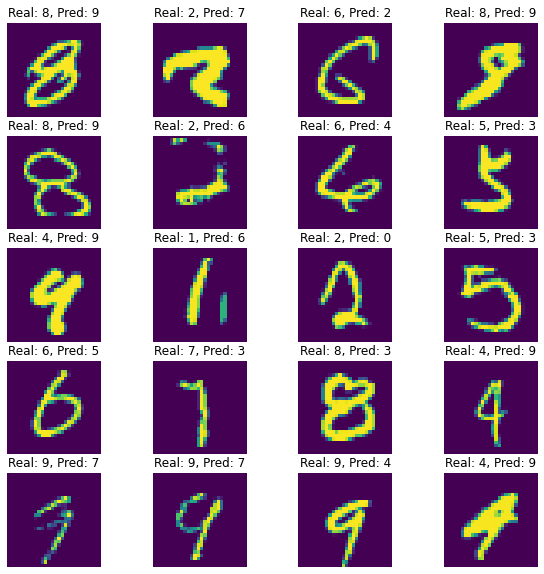

In [11]:
from sklearn.neural_network import MLPClassifier

epochs = 25
mlp = MLPClassifier(hidden_layer_sizes=(100, 200, 100), max_iter = epochs)

mlp.fit(x_train,y_train)

y_pred = mlp.predict(x_test)
eval = Evaluate(y_test, y_pred, x_test)
eval.get_evaluation_report()

#### Σύγκριση υλοποιήσεων

##### Χρόνος

In [20]:
%%time
network = MLP([100, 200, 100, 10], 28*28)

train_log = []
val_log = []

#Αυτά πρέπει να τρέχουν αφού έχετε φτιάξει σωστά τον κώδικα της MLP
for epoch in range(25):
    network.fit(x_train,y_train)
    
    train_log.append(np.mean(network.predict(x_train)==y_train))
    val_log.append(np.mean(network.predict(x_test)==y_test))
    
    clear_output()
    print("Epoch",epoch)

y_pred = network.predict(x_test)

Epoch 24
CPU times: user 52.2 s, sys: 12.9 s, total: 1min 5s
Wall time: 33.5 s


In [21]:
%%time
epochs = 25
mlp = MLPClassifier(hidden_layer_sizes=(100, 200, 100), max_iter = epochs)

mlp.fit(x_train,y_train)

y_pred = mlp.predict(x_test)

CPU times: user 44.1 s, sys: 16.7 s, total: 1min
Wall time: 31 s


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


##### Απόδοση
###### *βλ. δοκιμές έτοιμης και δικής υλοποίησης παραπάνω*

##### Σχολιασμός

* Παρά τις όποιες βελτιστοποιήσεις έγιναν με χρήση διαφόρων μέσων, η ήδη υπάρχουσα υλοποίηση τρέχει αισθητά πιό γρήγορα απ'τη δική μας.
* Μάλιστα όχι μόνο ολοκληρώνει γρηγορότερα, αλλά και πολύ καλύτερα αποτελέσματα.
* Γενικότερα (λογικά λόγω της διάδοσης και της απόδοσής που έχει) είναι αρκετά καλύτερη η υπάρχουσα υλοποίηση.
* Δοκιμάζοντας διάφορες τιμές για το learning rate (προφανώς με λίγο αυξημένο κίνδυνο για overfitting) παρατηρούμε ότι υπό κατάλληλες συνθήκες αυξάνονται οι μετρικές.

### Αξιολόγηση-Συμπεράσματα
---
Για προβλήματα σχετικά απλά σε φύση, όπως αυτό η παραδοχή δεσμευμένης ανεξαρτησίας που κάναμε στην υλοποίηση του Naive Bayes είναι αρκετά κοντά στην πραγματικότητα ούτως ώστε η απόδοση να είναι ικανοποιητική, ειδικά κρίνοντας από το πόσο γρήγορα τρέχει σε σχέση με τις υπόλοιπες υλοποιήσεις.  

Αντίθετα Multi-Layered Perceptrons είναι πολύ γενικότερα στη φύση τους και με καταλληλη δομή και χρόνο για training μπορούν να αποτελέσουν πολύ δυνατό εργαλείο για ταξινόμηση.

Τέλος όσον αφορά τους KNN ταξινομητές σημαντικό ρόλο σε ειδικότερα προβλήματα θα παίζει ο ορισμός της απόστασης δύο αντικειμένων του προβλήματος, ενώ ταυτόχρονα έχει ιδιαίτερα απλή υλοποίηση.